In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import yfinance as yf

%matplotlib inline

In [2]:
df = yf.download('TSLA', start='2018-07-15', end='2023-07-15')

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-16,20.780666,21.010668,20.416668,20.673332,20.673332,117280500
2018-07-17,20.587334,21.649332,20.566668,21.512667,21.512667,104943000
2018-07-18,21.666668,21.700001,21.083332,21.590000,21.590000,84363000
2018-07-19,21.088667,21.569332,20.934000,21.348667,21.348667,88729500
2018-07-20,21.415333,21.549334,20.780666,20.905333,20.905333,77433000
...,...,...,...,...,...,...
2023-07-10,276.470001,277.519989,265.100006,269.609985,269.609985,119425400
2023-07-11,268.649994,270.899994,266.369995,269.790009,269.790009,91972400
2023-07-12,276.329987,276.519989,271.459991,271.989990,271.989990,95672100


**Glossaries:**

- Open: The price at which the first transaction of the day occurs for a given stock.

- Close: The final price at which the last trade for a given stock occurs before the market closes.

- High: The highest price at which a stock was traded during the trading session.

- Low: The lowest price at which a stock was traded during the trading session.

## EDA: 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-07-16 to 2023-07-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


In [5]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

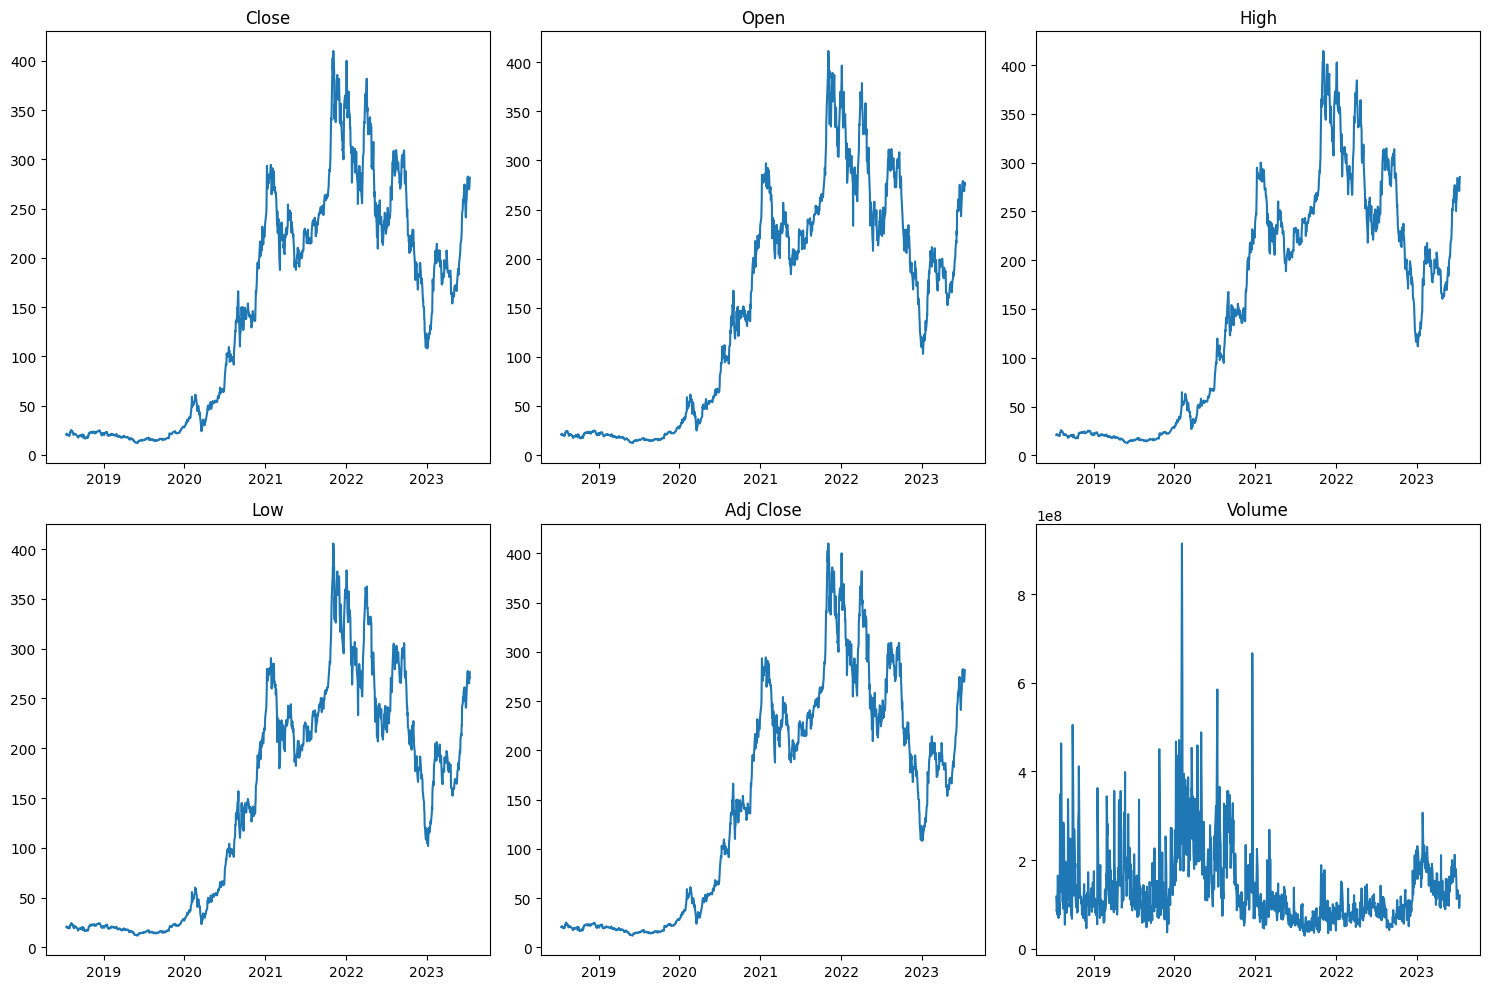

In [6]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[0,2]
ax4 = axes[1,0]
ax5 = axes[1,1]
ax6 = axes[1,2]

ax1.plot(df["Close"])
ax1.set_title("Close")
ax2.plot(df["Open"])
ax2.set_title("Open")
ax3.plot(df["High"])
ax3.set_title("High")
ax4.plot(df["Low"])
ax4.set_title("Low")
ax5.plot(df["Adj Close"])
ax5.set_title("Adj Close")
ax6.plot(df["Volume"])
ax6.set_title("Volume")
plt.tight_layout()

## moving average for close price:

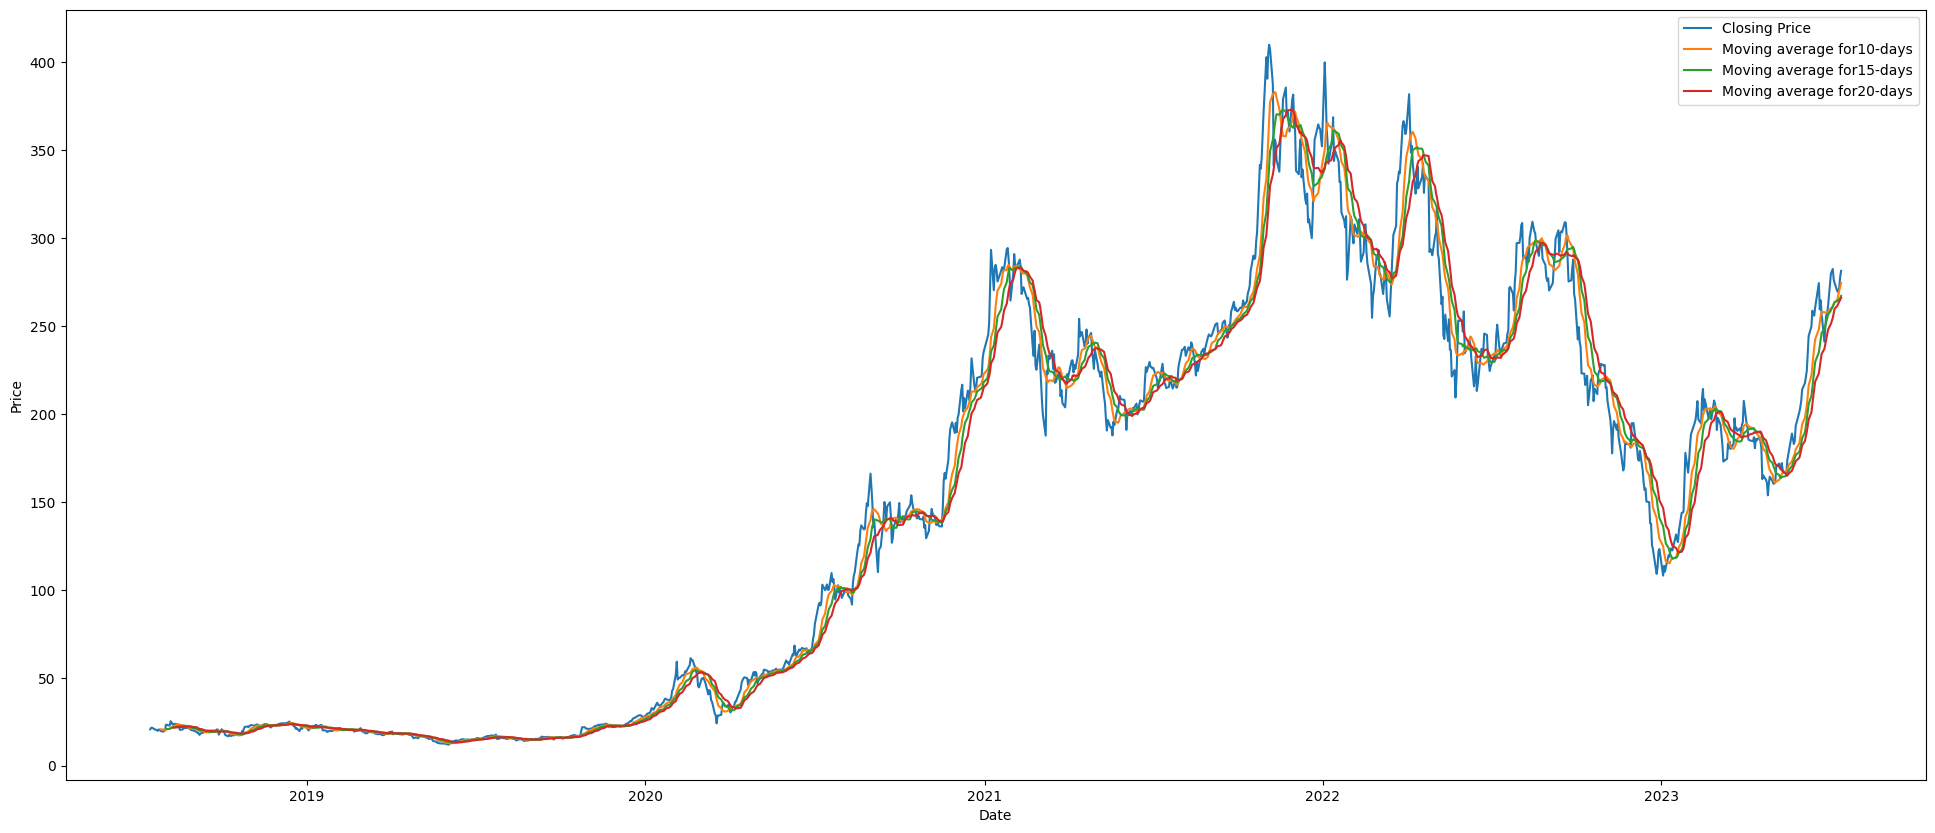

In [7]:
windows = [10, 15, 20]
plt.figure(figsize=(24,10))
plt.plot(df["Close"], label="Closing Price")
for window in windows:
    df["moving average"] = df["Close"].rolling(window=window).mean()
    plt.plot(df["moving average"], label=f"Moving average for{window}-days")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()

## Risk of investing in the stock:

Historical Volatility: 0.6652133765147848


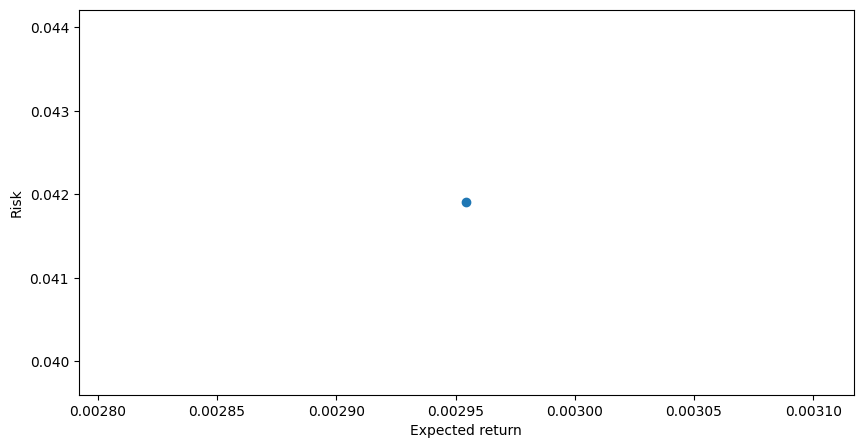

In [8]:
#calculating daily returns
df["Returns"] = df["Close"].pct_change()

var = df["Returns"]

new_var = var.dropna()

historical_volatility = var.std()*np.sqrt(252) #considering there are 252 working days in a year
print("Historical Volatility:", historical_volatility)

plt.figure(figsize=(10,5))
plt.scatter(new_var.mean(), new_var.std())
plt.xlabel("Expected return")
plt.ylabel("Risk")
plt.show()

**Note: Higher value indicates higher risk of investing**

## Using LSTM to model:

In [9]:
filepath = "C:/Users/anaya/Downloads/Data Sets/TSLA.csv"
data = pd.read_csv(filepath, usecols=['Date', 'Close'], parse_dates=True, index_col='Date')

In [10]:
data

,Close
Date,
2018-07-16,20.673332
2018-07-17,21.512667
2018-07-18,21.590000
2018-07-19,21.348667
2018-07-20,20.905333
...,...
2023-07-10,269.609985
2023-07-11,269.790009
2023-07-12,271.989990


**we will now do feature scaling by using min-max method which will map the values to [0,1] interval. Although it is not necessary, but it is a good practice because we do not want our model to be biased**

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #creating an object of class MinMaxScaler
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.02196269],
       [0.02407136],
       [0.02426565],
       ...,
       [0.65335023],
       [0.66819805],
       [0.67694094]])

**we will split the data into taining and testing data in ratio 90:10 which will form the base for predicting the data:**

In [12]:
np.random.seed(10)
Trainlen = int(len(scaled_data)*0.90)
Testlen = int(len(scaled_data) - Trainlen)
TrainData = scaled_data[0:Trainlen,:]
TestData = scaled_data[Trainlen:len(scaled_data),:]
print(len(TrainData), len(TestData))

1132 126


**Defining a function which will create an input-output pair. This function takes two inputs, viz dataset and the timesteps(the number of steps backpropogation uses to find the weights while training. So, if the timestep = 1, data at timestep t would be an input and data at timestep (t+1) would be an output.** 

In [13]:
def DatasetCreation(dataset, timesteps):
    DataX, DataY = [], []
    for i in range(0, len(dataset)-timesteps-1):
        a = dataset[i:(i+timesteps),0]
        DataX.append(a)
        DataY.append(dataset[i+timesteps,0])
    return np.array(DataX), np.array(DataY)

In [14]:
timesteps = 1
TrainX, TrainY = DatasetCreation(TrainData, timesteps=timesteps)
TestX, TestY = DatasetCreation(TestData, timesteps=timesteps)


In [15]:
TrainX = np.reshape(TrainX, (TrainX.shape[0], 1, TrainX.shape[1]))
TestX = np.reshape(TestX, (TestX.shape[0], 1, TestX.shape[1]))


In [16]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [17]:
model = Sequential()
model.add(LSTM(256, input_shape = (1, timesteps)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
model.fit(TrainX, TrainY, epochs=50, batch_size=1, verbose=1)
model.summary()

Epoch 1/50
1130/1130 [==============================] - 41s 6ms/step - loss: 0.0177 - accuracy: 0.0018
Epoch 2/50
1130/1130 [==============================] - 5s 5ms/step - loss: 0.0015 - accuracy: 0.0018
Epoch 3/50
1130/1130 [==============================] - 6s 5ms/step - loss: 0.0014 - accuracy: 0.0018
Epoch 4/50
1130/1130 [==============================] - 5s 5ms/step - loss: 0.0013 - accuracy: 0.0018
Epoch 5/50
1130/1130 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.0018
Epoch 6/50
1130/1130 [==============================] - 6s 5ms/step - loss: 0.0012 - accuracy: 0.0018
Epoch 7/50
1130/1130 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.0018
Epoch 8/50
1130/1130 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.0018
Epoch 9/50
1130/1130 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.0018
Epoch 10/50
1130/1130 [==============================] - 5s 5ms/step - loss: 0.00

In [18]:
score = model.evaluate(TrainX, TrainY, verbose=0)
print('Keras Model Loss = ',score[0])
print('Keras Model Accuracy = ',score[1])


Keras Model Loss =  0.00041132455226033926
Keras Model Accuracy =  0.0017699114978313446


In [19]:
TrainPred = model.predict(TrainX)
TestPred = model.predict(TestX)

4/4 [==============================] - 0s 7ms/step


In [20]:
TrainPred = scaler.inverse_transform(TrainPred)
TrainY = scaler.inverse_transform([TrainY])
TestPred = scaler.inverse_transform(TestPred)
TestY = scaler.inverse_transform([TestY])


In [21]:
TrainPredictPlot = np.empty_like(scaled_data)
TrainPredictPlot[:, :] = np.nan
TrainPredictPlot[1:len(TrainPred)+1, :] = TrainPred

In [22]:
TestPredictPlot = np.empty_like(scaled_data)
TestPredictPlot[:, :] = np.nan
TestPredictPlot[len(TrainPred)+(1*2)+1:len(scaled_data)-1, :] =TestPred

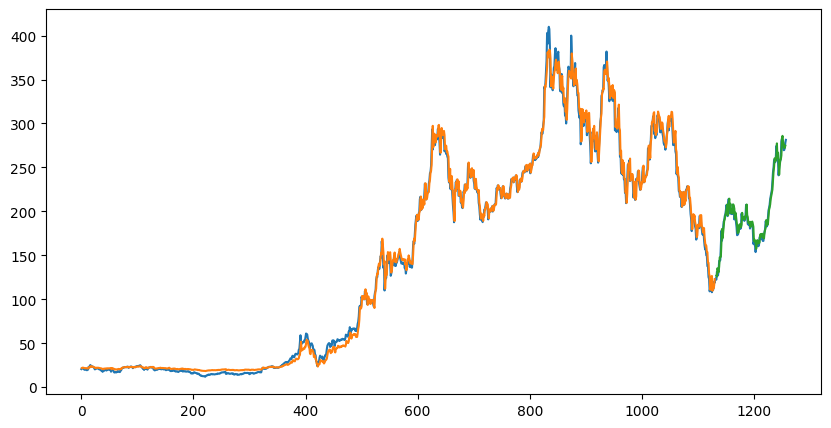

In [23]:
plt.figure(figsize=(10,5))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(TrainPredictPlot)
plt.plot(TestPredictPlot)
plt.show()
